In [15]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')

import os
os.environ["OMP_NUM_THREADS"] = "32"


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load sparse PCA analyses for identifying gene programs

In [16]:
codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_codes.csv', index_col=0)
codes.columns = codes.columns.astype(int)

total_codes = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_total_fibroblast_bulk_codes.csv', index_col=0)
total_codes.columns = total_codes.columns.astype(int)

comps = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_comps.csv', index_col=0)

Load mean transcriptional profiles for all perturbations

In [17]:
fibro_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
fibro_mean_pop.genes.index.name = 'gene_id'

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 5.935809373855591s.
Done.


Load guide library and annotate masked_active and expanded_masked_active guides identified by clustering

In [18]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
fibro_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [19]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

guide_library['masked_active'] = fibro_mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = fibro_mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)
guide_library['de_genes'] = fibro_mean_pop.cells['de_genes']

/tmp/ipykernel_914909/1543079379.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_914909/1543079379.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_library['masked_active'].fillna(False, inplace=True)
/tmp/ipykernel_914909/15

In [20]:
guide_library['masked_active_rpe1'].fillna(False, inplace=True)
guide_library['masked_active_fibro'].fillna(False, inplace=True)

/tmp/ipykernel_914909/737138646.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active_rpe1'].fillna(False, inplace=True)
/tmp/ipykernel_914909/737138646.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_library['masked_active_rpe1'].fillna(False, inplace=True)
/tmp/ipykernel_9

Load Human Protein Atlas clustered single cell data. We use pseudobulked expression according to their clustering. Certain samples are removed as they have aberrant expression characteristics compared to other tissues.

In [22]:
cell_type_expr = pd.read_csv('/data/norman/southark/external_datasets/human_protein_atlas/rna_single_cell_type_tissue.tsv', sep='\t', index_col=[0, 1, 2, 3, 4])['nTPM'].unstack(level=[2,3,4]).T

cell_type_expr = cell_type_expr.swaplevel(axis=1)
cell_type_expr = cell_type_expr[cell_type_expr.index.get_level_values(2).isin(['fibroblasts', 'smooth muscle cells','endometrial stromal cells'])]

cell_type_expr = cell_type_expr[~cell_type_expr.index.get_level_values(0).isin(['Early spermatids', 'Leydig cells', 'Late spermatids', 'Spermatocytes', 'Spermatogonia', 'Oocytes'])]
cell_type_expr = cell_type_expr.div(cell_type_expr.sum(axis=1), axis=0)

norm_cell_type_expr = cell_type_expr.copy()
norm_cell_type_expr = norm_cell_type_expr.loc[:,norm_cell_type_expr.mean()[(norm_cell_type_expr.mean() > 0)].index]
z_norm_cell_type_expr = (norm_cell_type_expr - norm_cell_type_expr.mean()).div(norm_cell_type_expr.std())

Identify guides that we think don't have off-target effects. In this analysis we are quite inclusive so ~5500 guides survive the filters below.

In [24]:
good_guides = guide_library.query('not seed_driven_fibro and not seed_driven_rpe1 and not bad_seed and cell_count_fibro >= 20 and ((pctl_change_fibro > 5) or (masked_active_fibro or expanded_masked_active or masked_active_rpe1))').index

In [25]:
gene_codes = total_codes.reindex(good_guides).dropna()
gene_codes['gene'] = gene_codes.index.map(lambda x: x.split('_')[0])
gene_codes = gene_codes.set_index('gene', append=True).swaplevel()

In [26]:
good_guides

Index(['AATF_GGAAGGGATTGGAGCCGTAT', 'AATF_GTGAAGGGATTGGAGCCGTA',
       'ACTL6A_GCAGCAGGACAGAAGGAGTT', 'ACTL6A_GGGGACTAGGAGGTGCGTCT',
       'ADAR_GAAGGCCTGAGAAGATACGT', 'ADAR_GCTCCGCTGCATGAGAACTA',
       'ADAR_GGAGGGGTTCGACTTGTAAC', 'ADNP2_GGGGCCTGTGGGAAGTGCCA',
       'ADNP_GGGGAGCTCTCGCGAGAACC', 'AEBP2_GGGCTCCGTAGCGCGTGTGC',
       ...
       'ZSCAN30_GCGGTGACCAAGTCGAGGTA', 'ZSCAN30_GGTGAGGCTTCACAGCGGTC',
       'ZSCAN5A_GGAAGCAGGAGTGAAGGAGC', 'ZSCAN9_GGGGGGTTGAGTCCGAAGCA',
       'ZSCAN9_GTCCGGCGTTCACCTTGCTT', 'ZXDA_GGGCGCGGGTTCTGCGGGCT',
       'ZXDA_GTGGTACTGGGTCTCTGGAA', 'ZXDB_GCCGGAGCCCAGCGGTCCGC',
       'ZXDC_GGGAGCGCCGGCACCTACGA', 'ZXDC_GTCCGAGCCGGACTCTACGC'],
      dtype='object', name='guide_identity', length=3364)

In [27]:
gene_codes.index.get_level_values(0).unique()

Index(['AATF', 'ACTL6A', 'ADAR', 'ADNP2', 'ADNP', 'AEBP2', 'AFF1', 'AFF2',
       'AHRR', 'AHR',
       ...
       'ZSCAN25', 'ZSCAN26', 'ZSCAN29', 'ZSCAN2', 'ZSCAN30', 'ZSCAN5A',
       'ZSCAN9', 'ZXDA', 'ZXDB', 'ZXDC'],
      dtype='object', name='gene', length=1443)

**In vitro program scores**: For each gene program and each gene, we identify the top 2 guides by absolute impact on that program and average them to produce a gene-level score. (In some cases this may for example average one strong active guide with a weak inactive guide that for example has a modest negative effect.)

In [28]:
# Get strongest guide per gene based on absolute magnitude across all columns
guide_strengths = gene_codes.abs().sum(axis=1)
top_guides = guide_strengths.groupby('gene').nlargest(1) 
# Get index for these top guides
top_guide_idx = top_guides.index.get_level_values(2)
top_guide_idx

Index(['AATF_GTGAAGGGATTGGAGCCGTA', 'ACTL6A_GCAGCAGGACAGAAGGAGTT',
       'ADAR_GAAGGCCTGAGAAGATACGT', 'ADNP_GGGGAGCTCTCGCGAGAACC',
       'ADNP2_GGGGCCTGTGGGAAGTGCCA', 'AEBP2_GTCGAAGCCCGGCAGGGCGT',
       'AFF1_GGAACCCGGTACCGCAGCTC', 'AFF2_GACGTTATCATCCCCGGATC',
       'AHR_GGTGGGGCCCTCAAGGAAGA', 'AHRR_GGGTCCGGCTGTCTCGGGTC',
       ...
       'ZSCAN23_GCTCCGCGAAACAGCGGTTC', 'ZSCAN25_GTGCTGTTCCGAACCCGGCG',
       'ZSCAN26_GGGTCCGCTCACCTGGTCAA', 'ZSCAN29_GGAAGTTCGGCAGCTCAACG',
       'ZSCAN30_GGTGAGGCTTCACAGCGGTC', 'ZSCAN5A_GGAAGCAGGAGTGAAGGAGC',
       'ZSCAN9_GGGGGGTTGAGTCCGAAGCA', 'ZXDA_GGGCGCGGGTTCTGCGGGCT',
       'ZXDB_GCCGGAGCCCAGCGGTCCGC', 'ZXDC_GTCCGAGCCGGACTCTACGC'],
      dtype='object', name='guide_identity', length=1443)

In [29]:
gene_codes_reduced = gene_codes.loc[pd.IndexSlice[:, top_guide_idx], :].droplevel(1)

In [30]:
good_targets = guide_library.loc[good_guides]['target_gene'].unique()
good_targets = np.intersect1d(gene_codes.index.get_level_values(0), norm_cell_type_expr.columns.get_level_values(0))
gene_codes = gene_codes.loc[good_targets]
gene_codes_reduced = gene_codes_reduced.loc[good_targets]

**In vivo correlation scores**: From the Human Protein Atlas data we extract the expression of specific markers of universal (PI16) and inflammatory (SPARC) fibroblasts. We then correlate the expression of these markers with the expression of all transcription factors.

In [31]:
PI16_expr = z_norm_cell_type_expr['PI16'].iloc[:, 0]
SPARC_expr = z_norm_cell_type_expr['SPARC'].iloc[:, 0]
COL3A1_expr = z_norm_cell_type_expr['COL3A1'].iloc[:, 0]
COL1A1_expr = z_norm_cell_type_expr['COL1A1'].iloc[:, 0]
LRRC15_expr = z_norm_cell_type_expr['LRRC15'].iloc[:, 0]
COL11A1_expr = z_norm_cell_type_expr['COL11A1'].iloc[:, 0]
CTHRC1_expr = z_norm_cell_type_expr['CTHRC1'].iloc[:, 0]
POSTN_expr = z_norm_cell_type_expr['POSTN'].iloc[:, 0]

In [32]:
tf_z_norm_cell_type_expr = z_norm_cell_type_expr.loc[:, z_norm_cell_type_expr.columns.get_level_values(0).isin(good_targets)].droplevel(1, axis=1)

In [33]:
PI16_corr = tf_z_norm_cell_type_expr.corrwith(PI16_expr).loc[gene_codes_reduced.index]
SPARC_corr = tf_z_norm_cell_type_expr.corrwith(SPARC_expr).loc[gene_codes_reduced.index]
COL3A1_corr = tf_z_norm_cell_type_expr.corrwith(COL3A1_expr).loc[gene_codes_reduced.index]
COL1A1_corr = tf_z_norm_cell_type_expr.corrwith(COL1A1_expr).loc[gene_codes_reduced.index]
LRRC15_corr = tf_z_norm_cell_type_expr.corrwith(LRRC15_expr).loc[gene_codes_reduced.index]
COL11A1_corr = tf_z_norm_cell_type_expr.corrwith(COL11A1_expr).loc[gene_codes_reduced.index]
CTHRC1_corr = tf_z_norm_cell_type_expr.corrwith(CTHRC1_expr).loc[gene_codes_reduced.index]
POSTN_corr = tf_z_norm_cell_type_expr.corrwith(POSTN_expr).loc[gene_codes_reduced.index]

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper')

class OutlierDetector:
    @staticmethod
    def find_iqr_outliers(series):
        """Traditional IQR method"""
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return series[(series < lower_bound) | (series > upper_bound)], lower_bound, upper_bound
    
    @staticmethod
    def find_zscore_outliers(series, threshold=3):
        """Z-score method"""
        z_scores = (series - series.mean()) / series.std()
        outliers = series[abs(z_scores) > threshold]
        lower_bound = series.mean() - threshold * series.std()
        upper_bound = series.mean() + threshold * series.std()
        return outliers, lower_bound, upper_bound
    
    @staticmethod
    def find_modified_zscore_outliers(series, threshold=3.5):
        """Modified Z-score method"""
        median = series.median()
        mad = stats.median_abs_deviation(series)
        modified_z_scores = 0.6745 * (series - median) / mad
        outliers = series[abs(modified_z_scores) > threshold]
        lower_bound = median - (threshold * mad / 0.6745)
        upper_bound = median + (threshold * mad / 0.6745)
        return outliers, lower_bound, upper_bound
    
    @staticmethod
    def find_isolation_forest_outliers(series1, series2, contamination=0.1):
        """Isolation Forest method"""
        X = pd.DataFrame({'x': series1, 'y': series2})
        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        yhat = iso_forest.fit_predict(X)
        outliers_idx = series1.index[yhat == -1]
        return outliers_idx
    
    @staticmethod
    def find_dbscan_outliers(series1, series2, eps=0.5, min_samples=5):
        """DBSCAN clustering method"""
        X = np.column_stack((
            (series1 - series1.mean()) / series1.std(),
            (series2 - series2.mean()) / series2.std()
        ))
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        outliers_idx = series1.index[clustering.labels_ == -1]
        return outliers_idx

In [35]:
def plot_and_identify_outliers(series1, series2, is_expressed, 
                             labels=None, context='explore', savefig=False,
                             method='iqr', **kwargs):
    """
    Create scatter plot with outlier detection and binary expression markers.
    
    Parameters:
    series1, series2: pandas Series with matching indices
    is_expressed: pandas Series with matching indices, boolean/binary values (True/1 for expressed)
    labels: list of strings for axis labels
    context: 'explore' or 'pub' for figure size
    savefig: bool, whether to save the figure
    method: str, outlier detection method ('iqr', 'zscore', 'modified_zscore', 
           'isolation_forest', 'dbscan')
    **kwargs: additional parameters for outlier detection methods
    """
    detector = OutlierDetector()
    
    # Convert to boolean if not already
    is_expressed = is_expressed.astype(bool)
    
    # Detect outliers based on selected method
    if method in ['isolation_forest', 'dbscan']:
        # For multivariate methods
        outlier_func = getattr(detector, f'find_{method}_outliers')
        outlier_indices = outlier_func(series1, series2, **kwargs)
        
        # Get individual dimension outliers using IQR for comparison
        x_outliers, _, _ = detector.find_iqr_outliers(series1)
        y_outliers, _, _ = detector.find_iqr_outliers(series2)
        
        # Find indices that are outliers in both dimensions
        both_outliers = x_outliers.index.intersection(y_outliers.index)
        
        # Find indices that are outliers in x only
        x_only_outliers = x_outliers.index.difference(both_outliers)
        
        # Find indices that are outliers in y only
        y_only_outliers = y_outliers.index.difference(both_outliers)
        
    else:
        # For univariate methods
        outlier_func = getattr(detector, f'find_{method}_outliers')
        x_outliers, x_lower, x_upper = outlier_func(series1, **kwargs)
        y_outliers, y_lower, y_upper = outlier_func(series2, **kwargs)
        
        # Find indices that are outliers in both dimensions
        both_outliers = x_outliers.index.intersection(y_outliers.index)
        
        # Find indices that are outliers in one dimension only
        x_only_outliers = x_outliers.index.difference(both_outliers)
        y_only_outliers = y_outliers.index.difference(both_outliers)
    
    # Set up the plot
    if context == 'explore':
        fig, ax = plt.subplots(figsize=(10, 8))
    else:  # context == 'pub'
        fig, ax = plt.subplots(figsize=(3.4, 3))
    
    # Plot non-outlier points based on expression
    non_outliers = series1.index.difference(x_only_outliers).difference(y_only_outliers).difference(both_outliers)
    
    # Expressed non-outliers (dots)
    expressed_non_outliers = non_outliers[is_expressed[non_outliers]]
    if len(expressed_non_outliers) > 0:
        ax.scatter(series1[expressed_non_outliers], series2[expressed_non_outliers], 
                  marker='o', s=25, alpha=0.5, color='gray', 
                  label='Expressed')
    
    # Not expressed non-outliers (x's)
    not_expressed_non_outliers = non_outliers[~is_expressed[non_outliers]]
    if len(not_expressed_non_outliers) > 0:
        ax.scatter(series1[not_expressed_non_outliers], series2[not_expressed_non_outliers],
                  marker='x', s=25, alpha=0.5, color='gray',
                  label='Not expressed')
    
    # Plot outliers with appropriate markers based on expression
    def plot_outliers(indices, color, label_prefix):
        if len(indices) > 0:
            # Expressed outliers (dots)
            expressed_outliers = indices[is_expressed[indices]]
            if len(expressed_outliers) > 0:
                ax.scatter(series1[expressed_outliers], series2[expressed_outliers],
                          marker='o', s=25, color=color, 
                          label=f'{label_prefix} (expressed)')
                
            # Not expressed outliers (x's)
            not_expressed_outliers = indices[~is_expressed[indices]]
            if len(not_expressed_outliers) > 0:
                ax.scatter(series1[not_expressed_outliers], series2[not_expressed_outliers],
                          marker='x', s=25, color=color,
                          label=f'{label_prefix} (not expressed)')
            
            # Add annotations for all outliers
            for idx in indices:
                ax.annotate(idx, (series1.loc[idx], series2.loc[idx]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8)
    
    # Plot outliers for each category
    plot_outliers(x_only_outliers, '#D99828', 'X outliers')  # yellow
    plot_outliers(y_only_outliers, '#CE6DA1', 'Y outliers')  # red
    plot_outliers(both_outliers, '#528FF0', 'Both axes outliers')  # blue
    
    # Add threshold lines if available (for univariate methods)
    if method not in ['isolation_forest', 'dbscan']:
        ax.axhline(y=y_lower, color='gray', linestyle='--', alpha=0.5)
        ax.axhline(y=y_upper, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=x_lower, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=x_upper, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels
    if labels and len(labels) >= 2:
        ax.set_xlabel(f'Correlation to {labels[0]} in vivo')
        ax.set_ylabel(f'Program {labels[1]} score')
    else:
        ax.set_xlabel('Correlation to expression')
        ax.set_ylabel('Program score')
    
    # Add legend with adjusted position and size
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    if savefig:
        label_str = f'{labels[0]}vs{labels[1]}' if labels else 'scatter'
        plt.savefig(f'{label_str}_{context}_{method}_hpa_outliers.pdf', 
                   bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    # Return outlier indices and expression counts
    return {
        'x_outliers': x_only_outliers,
        'y_outliers': y_only_outliers,
        'both_outliers': both_outliers,
        'expressed_genes': is_expressed[is_expressed].index.tolist(),
        'not_expressed_genes': is_expressed[~is_expressed].index.tolist(),
        'expression_counts': {
            'total_expressed': is_expressed.sum(),
            'total_not_expressed': (~is_expressed).sum()
        }
    }

In [36]:
expressed_fibro = guide_library[['target_gene', 'expressed_fibro']].drop_duplicates().fillna(False).set_index('target_gene')

/tmp/ipykernel_914909/1609468493.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  expressed_fibro = guide_library[['target_gene', 'expressed_fibro']].drop_duplicates().fillna(False).set_index('target_gene')


Number of expressed genes: 1150
Number of not expressed genes: 285


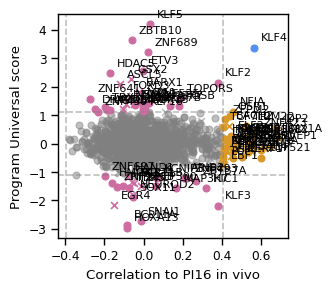

In [37]:
results = plot_and_identify_outliers(PI16_corr, gene_codes_reduced[31], 
                                                                    is_expressed = expressed_fibro['expressed_fibro'].loc[PI16_corr.index],
                                                                    context = 'pub',savefig = True,
                                                                    labels=['PI16', 'Universal'])

# Check results
print(f"Number of expressed genes: {results['expression_counts']['total_expressed']}")
print(f"Number of not expressed genes: {results['expression_counts']['total_not_expressed']}")

Number of expressed genes: 1150
Number of not expressed genes: 285


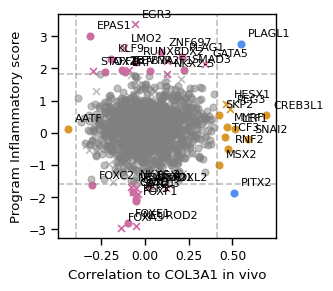

In [38]:
results = plot_and_identify_outliers(COL3A1_corr, gene_codes_reduced[32], 
                                    is_expressed = expressed_fibro['expressed_fibro'].loc[PI16_corr.index],
                                                                    context = 'pub', savefig = True,
                                                                    labels=['COL3A1', 'Inflammatory'])

# Check results
print(f"Number of expressed genes: {results['expression_counts']['total_expressed']}")
print(f"Number of not expressed genes: {results['expression_counts']['total_not_expressed']}")